# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

Neural Network編

## ライブラリインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import optuna
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## 関数

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
def df_stats(df):
    stats = []
    for col in df.columns:
        stats.append((col,
                      df[col].nunique(),
                      df[col].value_counts().index[0],
                      df[col].value_counts().values[0],
                      df[col].isnull().sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      df[col].dtype))
    return pd.DataFrame(stats, columns=['カラム名', 'カラムごとのユニーク値数', '最も出現頻度の高い値', '最も出現頻度の高い値の出現回数', '欠損損値の割合', '最も多いカテゴリの割合', 'Type'])

## データ読み込み・前処理

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv', header=None)

In [5]:
df_list = [train_df, test_df]

for df in df_list:
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})
    
    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    #df['p_label_mean'] = np.log(df['poutcome'].map(p_label_mean))
    #df.drop(['poutcome'], axis=1, inplace=True)
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    #df['dayofyear'] = df['month'] * 31 + df['day']
    df['datetime'] = pd.to_datetime('2012/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d')
    df['dayofyear'] = df['datetime'].dt.dayofyear
    #df['dayofweek'] = df['datetime'].dt.dayofweek
    df.drop(['datetime'], axis=1, inplace=True)

    df['duration'] = np.log(df['duration'] + 1)

    #df['bpp'] = np.log((df['balance'] - df['balance'].min()) / (df['pdays'] + 2) + 1)
    #df['cdp'] = (df['campaign'] - df['previous']) * df['duration']
    
    df.drop(['pdays'], axis=1, inplace=True)
    df.drop(['balance'], axis=1, inplace=True)
    
    df.drop(['id'], axis=1, inplace=True)

In [6]:
y = train_df.pop('y')

In [7]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 2.89 MB
Memory usage after optimization is: 0.41 MB
Decreased by 85.7%
Memory usage of dataframe is 1.93 MB
Memory usage after optimization is: 0.28 MB
Decreased by 85.7%


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        27100 non-null  int8   
 1   job        27100 non-null  int8   
 2   marital    27100 non-null  int8   
 3   education  27100 non-null  int8   
 4   housing    27100 non-null  int8   
 5   loan       27100 non-null  int8   
 6   contact    27100 non-null  int8   
 7   day        27100 non-null  int8   
 8   month      27100 non-null  int8   
 9   duration   27100 non-null  float16
 10  campaign   27100 non-null  int8   
 11  previous   27100 non-null  int8   
 12  poutcome   27100 non-null  int8   
 13  dayofyear  27100 non-null  int16  
dtypes: float16(1), int16(1), int8(12)
memory usage: 423.6 KB


In [9]:
train_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,2.710000e+04,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,0.583727,0.127269,0.788007,16.700443,6.003542,inf,1.775830,0.085720,1.855683,168.623579
std,7.816417,2.669990,0.872384,0.727044,0.492949,0.333281,0.498535,8.576252,2.135158,7.719727e-01,0.950045,0.365889,0.467181,65.155774
min,22.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,3.000000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804688e+00,1.000000,0.000000,2.000000,136.000000
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.070312e+00,1.000000,0.000000,2.000000,148.000000
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.847656e+00,2.000000,0.000000,2.000000,199.000000
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031250e+00,5.000000,3.000000,3.000000,336.000000


In [10]:
df_stats(train_df)

,カラム名,カラムごとのユニーク値数,最も出現頻度の高い値,最も出現頻度の高い値の出現回数,欠損損値の割合,最も多いカテゴリの割合,Type
0,age,42,31.000000,4464,0.0,16.472325,int8
1,job,11,3.000000,5957,0.0,21.981550,int8
2,marital,3,2.000000,17565,0.0,64.815498,int8
3,education,4,2.000000,15955,0.0,58.874539,int8
4,housing,2,1.000000,15819,0.0,58.372694,int8
5,loan,2,0.000000,23651,0.0,87.273063,int8
6,contact,3,1.000000,19147,0.0,70.653137,int8
7,day,30,27.000000,4129,0.0,15.236162,int8
8,month,12,5.000000,11232,0.0,41.446494,int8
9,duration,140,5.070312,5759,0.0,21.250923,float16


In [11]:
# Clear clutter from previous Keras session graphs.
clear_session()

## Entity Embedding

カテゴリ変数、順序変数

age, job, marital, education, housing, loan, contact, day, month, campaign, previous, poutcome

In [12]:
input_age = Input(shape=(1,), name="input_age")
embed_age = Embedding(91, 16, name="embed_age")(input_age)
flatt_age = Flatten(name="flatt_age")(embed_age)

input_job = Input(shape=(1,), name="input_job")
embed_job = Embedding(13, 6, name="embed_job")(input_job)
flatt_job = Flatten(name="flatt_job")(embed_job)

input_marital = Input(shape=(1,), name="input_marital")
embed_marital = Embedding(3, 2, name="embed_marital")(input_marital)
flatt_marital = Flatten(name="flatt_marital")(embed_marital)

input_education = Input(shape=(1,), name="input_education")
embed_education = Embedding(4, 3, name="embed_education")(input_education)
flatt_education = Flatten(name="flatt_education")(embed_education)

input_housing = Input(shape=(1,), name="input_housing")
embed_housing = Embedding(2, 4, name="embed_housing")(input_housing)
flatt_housing = Flatten(name="flatt_housing")(embed_housing)

input_loan = Input(shape=(1,), name="input_loan")
embed_loan = Embedding(2, 4, name="embed_loan")(input_loan)
flatt_loan = Flatten(name="flatt_loan")(embed_loan)

input_contact = Input(shape=(1,), name="input_contact")
embed_contact = Embedding(3, 2, name="embed_contact")(input_contact)
flatt_contact = Flatten(name="flatt_contact")(embed_contact)

input_day = Input(shape=(1,), name="input_day")
embed_day = Embedding(32, 8, name="embed_day")(input_day)
flatt_day = Flatten(name="flatt_day")(embed_day)

input_month = Input(shape=(1,), name="input_month")
embed_month = Embedding(13, 6, name="embed_month")(input_month)
flatt_month = Flatten(name="flatt_month")(embed_month)

input_campaign = Input(shape=(1,), name="input_campaign")
embed_campaign = Embedding(6, 3, name="embed_campaign")(input_campaign)
flatt_campaign = Flatten(name="flatt_campaign")(embed_campaign)

input_previous = Input(shape=(1,), name="input_previous")
embed_previous = Embedding(4, 3, name="embed_previous")(input_previous)
flatt_previous = Flatten(name="flatt_previous")(embed_previous)

input_poutcome = Input(shape=(1,), name="input_poutcome")
embed_poutcome = Embedding(4, 3, name="embed_poutcome")(input_poutcome)
flatt_poutcome = Flatten(name="flatt_poutcome")(embed_poutcome)


## その他の変数

duration, dayofyear

In [13]:
input_duration = Input(shape=(1,), name="input_duration")
dense_duration = Dense(20, name="fc_duration")(input_duration)

input_dayofyear = Input(shape=(1,), name="input_dayofyear")
dense_dayofyear = Dense(30, name="fc_dayofyear")(input_dayofyear)

#input_cdp = Input(shape=(1,), name="input_cdp")
#dense_cdp = Dense(30, name="fc_cdp")(input_cdp)

## ネットワーク接続

In [14]:
concat_layers = [
    flatt_age,
    flatt_job,
    flatt_marital,
    flatt_education,
    flatt_housing,
    flatt_loan,
    flatt_contact,
    flatt_day,
    flatt_month,
    flatt_campaign,
    flatt_previous,
    flatt_poutcome,
    dense_duration,
    dense_dayofyear,
#    dense_cdp,
]

x = Concatenate()(concat_layers)

x = Activation("relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)

output_layer = Dense(1, activation="sigmoid")(x)

## モデル定義

In [15]:
input_layers = [
    input_age,
    input_job,
    input_marital,
    input_education,
    input_housing,
    input_loan,
    input_contact,
    input_day,
    input_month,
    input_campaign,
    input_previous,
    input_poutcome,
    input_duration,
    input_dayofyear,
#    input_cdp,
]

model = Model(input_layers, output_layer)

In [16]:
model.compile(
    loss=losses.mean_squared_error,
    optimizer=Adam(),
    metrics=[AUC()]
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_age (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_job (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_marital (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_education (InputLayer)    [(None, 1)]          0                                            
_______________________________________________________________________________________

In [17]:
x = {
    "input_age": train_df[["age"]],
    "input_job": train_df[["job"]],
    "input_marital": train_df[["marital"]],
    'input_education': train_df[["education"]],
    "input_housing": train_df[["housing"]],
    "input_loan": train_df[["loan"]],
    "input_contact": train_df[["contact"]],
    "input_day": train_df[["day"]],
    "input_month": train_df[["month"]],
    "input_campaign": train_df[["campaign"]],
    "input_previous": train_df[["previous"]],
    "input_poutcome": train_df[["poutcome"]],
    "input_duration": train_df[["duration"]],
    "input_dayofyear": train_df[["dayofyear"]],
#    "input_cdp": train_df[["cdp"]],
}


## 学習

In [18]:
validation_split = 0.2
batch_size = 32
epochs = 100


In [19]:
history = model.fit(
    x,
    y,
    validation_split=validation_split,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor="val_auc",
            patience=3,
            mode='max',
            verbose=1,
            restore_best_weights=True,
        )
    ]
)


Epoch 1/100
678/678 [==============================] - 7s 10ms/step - loss: 0.0716 - auc: 0.5733 - val_loss: 0.0757 - val_auc: 0.6739
Epoch 2/100
678/678 [==============================] - 6s 10ms/step - loss: 0.0707 - auc: 0.5960 - val_loss: 0.0701 - val_auc: 0.8083
Epoch 3/100
678/678 [==============================] - 7s 10ms/step - loss: 0.0618 - auc: 0.7573 - val_loss: 0.0603 - val_auc: 0.8331
Epoch 4/100
678/678 [==============================] - 7s 10ms/step - loss: 0.0582 - auc: 0.8069 - val_loss: 0.0614 - val_auc: 0.8295
Epoch 5/100
678/678 [==============================] - 7s 10ms/step - loss: 0.0574 - auc: 0.8130 - val_loss: 0.0622 - val_auc: 0.8297
Epoch 6/100
678/678 [==============================] - 7s 10ms/step - loss: 0.0569 - auc: 0.8179 - val_loss: 0.0586 - val_auc: 0.8403
Epoch 7/100
678/678 [==============================] - 7s 10ms/step - loss: 0.0563 - auc: 0.8244 - val_loss: 0.0589 - val_auc: 0.8353
Epoch 8/100
678/678 [==============================] - 7s 10ms

## 評価

In [20]:
max(history.history['val_auc'][-4:])


0.8403440117835999

In [21]:
results = pd.DataFrame(history.history)

<AxesSubplot:>

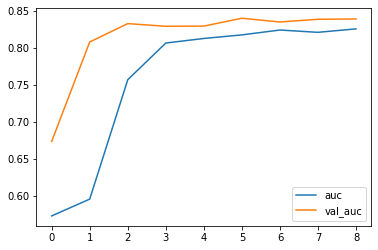

In [22]:
results[["auc", "val_auc"]].plot()

<AxesSubplot:>

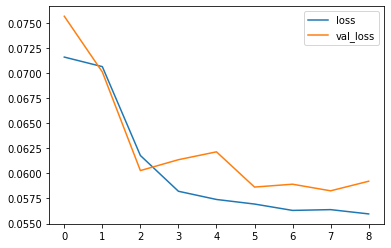

In [23]:
results[["loss", "val_loss"]].plot()

## 推論

In [24]:
x = {
    "input_age": test_df[["age"]],
    "input_job": test_df[["job"]],
    "input_marital": test_df[["marital"]],
    'input_education': test_df[["education"]],
    "input_housing": test_df[["housing"]],
    "input_loan": test_df[["loan"]],
    "input_contact": test_df[["contact"]],
    "input_day": test_df[["day"]],
    "input_month": test_df[["month"]],
    "input_campaign": test_df[["campaign"]],
    "input_previous": test_df[["previous"]],
    "input_poutcome": test_df[["poutcome"]],
    "input_duration": test_df[["duration"]],
    "input_dayofyear": test_df[["dayofyear"]],
#    "input_cdp": train_df[["cdp"]],
}


In [25]:
test_pred = model.predict(x)

In [26]:
test_pred

array([[0.6505776 ],
       [0.12244181],
       [0.0144842 ],
       ...,
       [0.02372411],
       [0.01191203],
       [0.13805728]], dtype=float32)

In [27]:
submit_df[1] = test_pred
submit_df.to_csv('submit-nn.csv', header=False, index=False)